# Variational Bayesian Last Layers for Bayesian Optimization

- Contributors: brunzema
- Last updated: Feb 13, 2025
- BoTorch version: 0.9.6(dev), commit hash: dccda59d8ef51d8074de82fdb5614bad2db0ee96 UPDATE!

In this notebook, we will demonstrate how to use variational Bayesian last layers (VBLLs) for Bayesian optimization [1, 2].

[1] P. Brunzema, M. Jordahn, J. Willes, S. Trimpe, J. Snoek, J. Harrison. [Bayesian Optimization via Continual Variational Last Layer Training](https://arxiv.org/abs/2412.09477). International Conference on Learning Representations (ICLR), 2025.

[2] J. Harrison, J. Willes, J. Snoek. [Variational Bayesian Last Layers](https://arxiv.org/abs/2404.11599). International Conference on Learning Representations (ICLR), 2024.


# Introduction to the VBLL Model

Bayesian optimization (BO) relies on surrogate models that provide uncertainty-aware predictions. Usually, Gaussian processes are the goto choice due to their analytical tractability, but they can limiting for input spaces that are non-Euclidean where careful choise of the kernel is curcial. Here, Bayesian neural networks are promissing as they automatically learn the correlations.

Variational Bayesian Last Layer (VBLL) [2] models provide a practical and scalable way to approximate Bayesian inference in neural networks. Instead of placing a prior over all network weights, VBLL only model the uncertainty on the parameters on the last layer while keeping the feature extractor deterministic. This setup allows the model to retain the expressive power of deep learning while maintaining well-calibrated uncertainty estimates.

In VBLL, we model the output as a generalized linear model with learned features $\phi_{\theta}$ as:

$$
    y = \mathbf{w}^\top \phi_{\theta} (\mathbf{x}) + \varepsilon
$$

where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$.
VBLL models use a variational posterior distribution on the weights as $\mathbf{w} \sim q(\mathbf{w})$ with $q(\mathbf{w}) = \mathcal{N}(\bar{\mathbf{w}}, S)$ where $\bar{\mathbf{w}}$ is the mean and $S$ the full covariance of a multivariate normal distribution (for more information, see [1,2]).
Through conjugacy, we yield the posterior predictive

$$
    p(y \mid \mathbf{x}, \mathcal{D}_T, \theta) = \mathcal{N} \big( \bar{\mathbf{w}}_T^\top \phi_{\theta}(\mathbf{x}), \, \phi_{\theta}(\mathbf{x})^\top S_T \phi_{\theta}(\mathbf{x}) + \sigma^{2} \big).
$$

This predictive can then be used in downsteam tasks such as Bayesian optimization (BO).

## The VBLLs on Toy Data

Before using the VBLL model in the context of Bayesian Optimization, let's see how the interface of the model looks. The current implementation allows for passing a full backbone to the mode. This backbone  could be any neural network architecture that outputs a feature vector of dimension M (input to the VBLL head), such as a pretrained MLP, GNN, or some other problem-specific architecture. If no backbone is provided, a standard MLP is created. For training, [1] discusses continual learning approaches which will be added to the implementation, but in the following, we will not go into detail. See the docstring of `model.fit` for the different options for configuring the optimization and the training.

Below, we use the model in a 1D regression example.


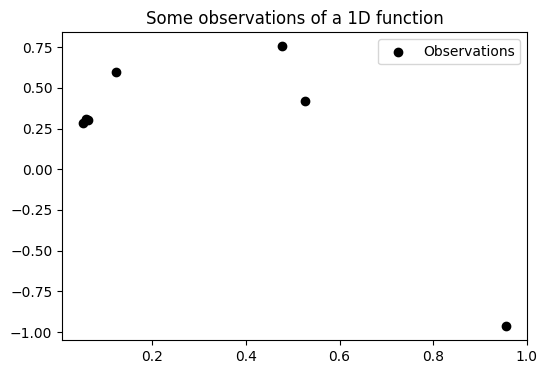

In [9]:
import matplotlib.pyplot as plt
import torch
from botorch_community.models.vblls import VBLLModel

torch.set_default_dtype(torch.float64)
torch.manual_seed(42)


def objective(x, noise=True):
    out = torch.sin(x * 5)
    if noise:
        out += 0.05 * torch.randn_like(x)
    return out


X = torch.rand(7, 1)
Y = objective(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_title("Some observations of a 1D function")
ax.scatter(X, Y, c="k", label="Observations")
ax.legend()
plt.show()

In [ ]:
model = VBLLModel(
    in_features=1,
    hidden_features=64,
    num_layers=3,
    out_features=1,
)

# lets print the model, we can see the MLP backbone and the VBLL regression head
print(model)

# fit the model on the data -- it is also possible to specify the optimizer
# throught `optimizer_settings` (see docstring)
model.fit(X, Y)

VBLLNetwork(
  (activation): ELU(alpha=1.0)
  (backbone): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (head): Regression()
)
Early stopping at epoch  6797  with loss  1.9734342403916378


Now we can use the model in the same way as a Gaussian process. Note, below is the exact same code as one would use with a GPyTorch model!


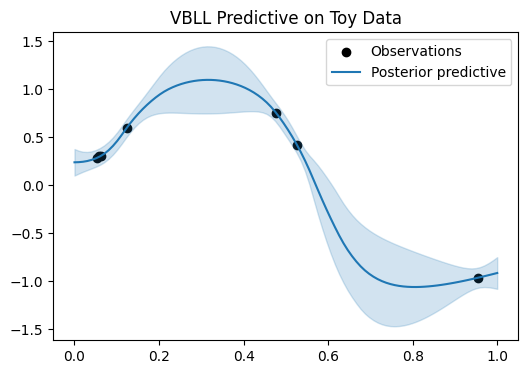

In [11]:
test_X = torch.linspace(0, 1, 100)
with torch.no_grad():
    posterior = model.posterior(test_X.view(-1, 1))
mean, std = posterior.mean.squeeze(), posterior.variance.sqrt().squeeze()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_title("VBLL Predictive on Toy Data")
ax.scatter(X, Y, c="k", label="Observations")
ax.plot(test_X, mean, label="Posterior predictive", color="tab:blue")
ax.fill_between(test_X, mean - 2 * std, mean + 2 * std, alpha=0.2, color="tab:blue")
ax.legend()
plt.show()

## Thompson sampling with VBLLs

VBLLs yield a Gaussian predictive distribution, and thus most acquisition functions that are straightforward to compute for Gaussian Processes (GPs) are also straightforward for VBLLs. Moreover, parametric VBLLs are especially well-suited for Thompson sampling.

For a Thompson sample, we simply sample from the variational posterior of $\mathbf{w}$ at iteration $t$ and then construct a sample from the predictive $\hat{f}$ as a generalized linear model:

\begin{aligned}
\text{First:} &\quad \hat{\mathbf{w}} \sim q(\mathbf{w}) \\
\text{Second:} &\quad \hat{f} (\mathbf{x}) \coloneqq \hat{\mathbf{w}}^\top \phi_{\theta} (\mathbf{x}).
\end{aligned}

We can directly leverage this in BO to choose the next query location as $\mathbf{x}_{t+1} = \arg\max_{\mathbf{x} \in \mathcal{X}} \hat{f} (\mathbf{x})$. Since the sample is a linear model, we can numerically optimize the sample path as we can simply calculate gradients of the sample.


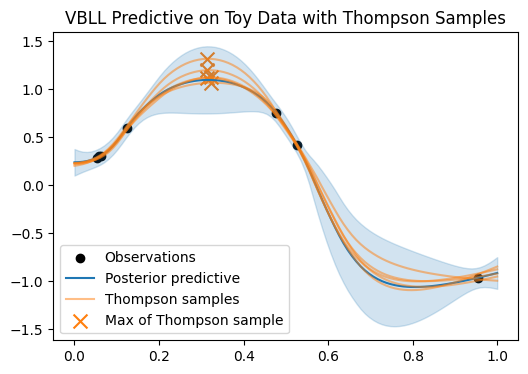

In [ ]:
def plot_model(
    model,
    x,
    y,
    new_data=None,
    show_objective=False,
    show_samples=False,
    title="VBLL Predictive on Toy Data with Thompson Samples",
):
    x_test = torch.linspace(0, 1, 100)
    with torch.no_grad():
        posterior = model.posterior(x_test.view(-1, 1))
    mean, std = posterior.mean.squeeze(), posterior.variance.sqrt().squeeze()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    ax.set_title(title)
    ax.scatter(x, y, c="k", label="Observations")

    if new_data is not None:
        x_new, y_new = new_data
        ax.scatter(x_new, y_new, c="r", label="New observations")

    if show_objective:
        ax.plot(x_test, objective(x_test, noise=False), label="Objective", color="k")

    ax.plot(x_test, mean, label="Posterior predictive", color="tab:blue")

    # Posterior samples
    if show_samples:
        with torch.no_grad():
            for i in range(5):
                ts_sample = (
                    model.sample()
                )  # a sample is essentially a standard MLP (nn.Module)
                ts_mean = ts_sample(x_test.view(-1, 1)).squeeze()
                ax.plot(
                    x_test,
                    ts_mean,
                    color="tab:orange",
                    alpha=0.5,
                    label="Thompson samples" if i == 0 else None,
                )

                # show max of the samples
                max_idx = ts_mean.argmax()
                ax.scatter(
                    x_test[max_idx],
                    ts_mean[max_idx],
                    color="tab:orange",
                    marker="x",
                    s=100,
                    label="Max of Thompson sample" if i == 0 else None,
                )

    ax.fill_between(x_test, mean - 2 * std, mean + 2 * std, alpha=0.2, color="tab:blue")
    ax.legend()
    plt.show()


plot_model(model, X, Y, show_samples=True)

# Bayesian optimization with VBLLs


Next, lets us the VBLLs for Bayesian optimization to optimize the toy function above using Thompson sampling. Note that setting up the Thompson sampling is similar to the standard `MaxPosteriorSampling` in BoTorch. We also include logEI as an acquisition function to demonstrate the staight-forward use of the model also for other acquisition functions. To visualize the optimization, set the `plot_bo_step` flag to True.

In [ ]:
from botorch_community.acquisition.bll_thompson_sampling import BLLMaxPosteriorSampling
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf

batch_size = 1
plot_bo_step = False

acq_functions = ["ts", "ei"]  # "ei" or "ts"

# lets define the optimizer settings (the values below are the default values)
optimizer_settings = {
    "num_epochs": 10_000,  # number of epochs
    "freeze_backbone": False,  # whether to freeze the backbone / features during training
    "patience": 100,  # patience for early stopping (if no improvement for `patience` epochs, stop training)
    "batch_size": 32,  # mini-batch size
    "optimizer": torch.optim.AdamW,  # optimizer
    "wd": 1e-4,  # weight decay
    "lr": 1e-3,  # learning rate
    "clip_val": 1.0,  # gradient clipping value
}

results = {}
for acq in acq_functions:
    torch.manual_seed(42)

    X_bo = torch.rand(2, 1)
    Y_bo = objective(X_bo)

    for iteration in range(10):
        print(
            f"Acquisition function {acq.upper()}\t Iteration {iteration}) \t Best Value: {Y_bo.max().item()}"
        )

        # initialize the model
        model = VBLLModel(
            in_features=1,
            hidden_features=64,
            num_layers=3,
            out_features=1,
        )
        model.fit(X_bo, Y_bo, optimization_settings=optimizer_settings)

        if acq == "ts":
            # Thompson sampling as acquisition function
            thompson_sampling = BLLMaxPosteriorSampling(
                model=model,
                num_restarts=5,
            )
            X_next = thompson_sampling(num_samples=batch_size)

        elif acq == "ei":
            bounds = torch.tensor([[0.0] * 1, [1.0] * 1])
            # (log) Expected Improvement as acquisition function
            acq_func = LogExpectedImprovement(model, best_f=Y_bo.max())
            X_next, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=bounds,
                q=1,
                num_restarts=5,
                raw_samples=20,
            )

        # evaluate the objective
        Y_next = objective(X_next)

        # plot the model, the thompson samples and the objective
        if plot_bo_step:
            plot_model(
                model,
                X_bo,
                Y_bo,
                new_data=(X_next, Y_next),
                show_objective=True,
                title=f"Iteration {iteration}",
            )

        # update the data
        X_bo = torch.cat([X_bo, X_next])
        Y_bo = torch.cat([Y_bo, Y_next])

    results[acq] = Y_bo

Acquisition function TS	 Iteration 0) 	 Best Value: 0.3209060289482761
Early stopping at epoch  5553  with loss  11.771127002794948
Acquisition function TS	 Iteration 1) 	 Best Value: 0.3209060289482761
Early stopping at epoch  2891  with loss  7.475776178079064
Acquisition function TS	 Iteration 2) 	 Best Value: 0.3209060289482761
Early stopping at epoch  4395  with loss  5.0714997476317984
Acquisition function TS	 Iteration 3) 	 Best Value: 1.031779544394597
Early stopping at epoch  4836  with loss  3.707499221305043
Acquisition function TS	 Iteration 4) 	 Best Value: 1.0374862864112717
Early stopping at epoch  10000  with loss  2.911917186781568
Acquisition function TS	 Iteration 5) 	 Best Value: 1.0374862864112717
Early stopping at epoch  4826  with loss  2.1837356449442256
Acquisition function TS	 Iteration 6) 	 Best Value: 1.0374862864112717
Early stopping at epoch  10000  with loss  10.05054520416372
Acquisition function TS	 Iteration 7) 	 Best Value: 1.0374862864112717
Early st

Lets plot the performance over the number of iterations.


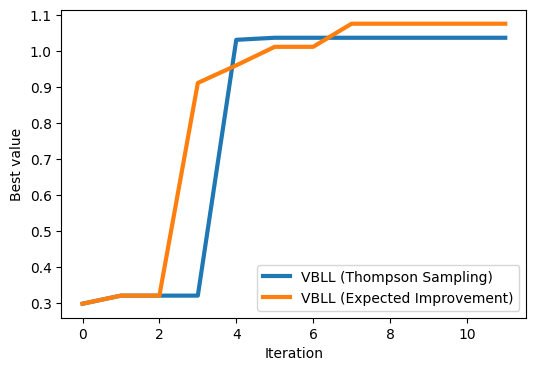

In [6]:
import numpy as np


def plot_performance(results, labels):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    observations = [results[key] for key in results.keys()]
    for obs, label in zip(observations, labels):
        best_value = np.maximum.accumulate(obs.numpy())
        ax.plot(best_value, marker="", lw=3, label=label)

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best value")
    ax.legend()
    plt.show()


plot_performance(results, ["VBLL (Thompson Sampling)", "VBLL (Expected Improvement)"])